In [1]:
import torch 
import torch_geometric as pyg
import pandas as pd
import numpy as np
import omnipath as op 
from matplotlib import pyplot as plt 
import torch_geometric as pyg 
import copy 
import umap
import seaborn as sbn

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Environment import Environment
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc             # required to unpickle data 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = torch.load('../../processed_data/data.pt')

row,col = data.edge_index_dict['function','to','function']
N = len(data.node_names_dict['function'])
iD = pyg.utils.degree(row, num_nodes=N).detach().cpu().numpy()
oD = pyg.utils.degree(col, num_nodes=N).detach().cpu().numpy()
D = iD + oD

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'node_name':data.node_names_dict['function'], 'prob':result_dict['node_prob'].ravel(), 'degree':D, 'in_degree':iD, 'out_degree':oD})
res = res.assign(From=lambda x: [xx.split('__')[1] for xx in x.node_name])
res = res.merge(uni2sym, on='From', how='left')

res.sort_values('prob', ascending=False).head(20)

,node_name,prob,degree,in_degree,out_degree,From,To
1049,PROTEIN__P04637,1.000000,1268.0,834.0,434.0,P04637,TP53
2414,PROTEIN__P52333,0.999999,204.0,96.0,108.0,P52333,JAK3
1892,PROTEIN__P29350,0.999998,252.0,160.0,92.0,P29350,PTPN6
6304,RNA__P04637,0.999994,90.0,1.0,89.0,P04637,TP53
5213,PROTEIN__Q9Y5B0,0.999992,38.0,11.0,27.0,Q9Y5B0,CTDP1
1097,PROTEIN__P06239,0.999991,342.0,249.0,93.0,P06239,LCK
2391,PROTEIN__P51692,0.999990,155.0,60.0,95.0,P51692,STAT5B
1722,PROTEIN__P23458,0.999990,305.0,160.0,145.0,P23458,JAK1
1763,PROTEIN__P24928,0.999988,49.0,3.0,46.0,P24928,POLR2A
2580,PROTEIN__P61073,0.999977,155.0,58.0,97.0,P61073,CXCR4


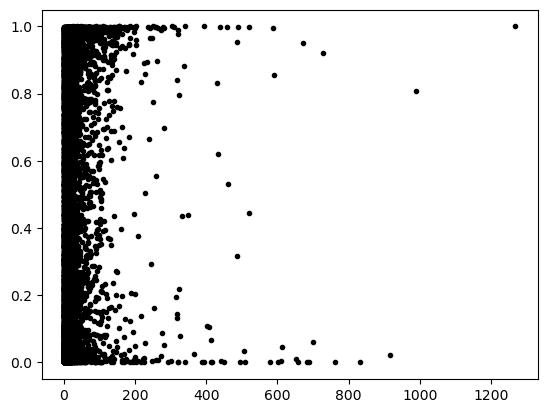

In [3]:
plt.figure()
plt.plot(res.degree, res.prob, 'k.')
plt.show()

In [4]:
row,col = data.edge_index_dict['input', 'to', 'function']
dti_idxs = col[row == 0] # 'DRUG__BRD-K60230970'
targs = np.array(data.node_names_dict['function'])[dti_idxs]
res[lambda x: x.node_name.isin(targs)].sort_values('prob', ascending=False)

,node_name,prob,degree,in_degree,out_degree,From,To
1843,PROTEIN__P28062,0.851578,30.0,27.0,3.0,P28062,PSMB8
2116,PROTEIN__P40306,0.845935,32.0,27.0,5.0,P40306,PSMB10
1149,PROTEIN__P07858,0.810592,18.0,12.0,6.0,P07858,CTSB
1849,PROTEIN__P28070,0.787218,31.0,27.0,4.0,P28070,PSMB4
1787,PROTEIN__P25786,0.756141,29.0,26.0,3.0,P25786,PSMA1
1790,PROTEIN__P25789,0.719706,30.0,26.0,4.0,P25789,PSMA4
2192,PROTEIN__P43235,0.703867,11.0,6.0,5.0,P43235,CTSK
1788,PROTEIN__P25787,0.611391,27.0,26.0,1.0,P25787,PSMA2
6,PROTEIN__A5LHX3,0.567302,27.0,26.0,1.0,A5LHX3,PSMB11
1851,PROTEIN__P28074,0.553203,29.0,26.0,3.0,P28074,PSMB5


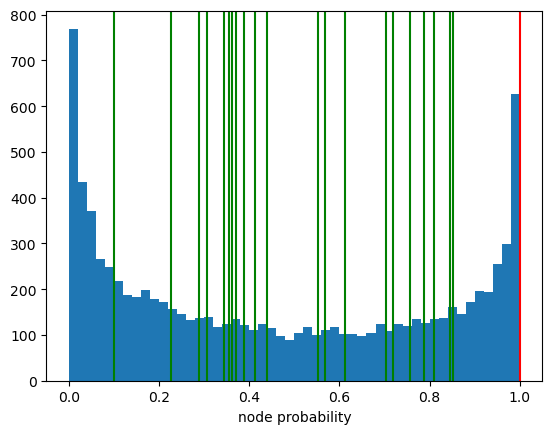

In [5]:
plt.figure()
plt.hist(res.prob, bins=50)
for targ in targs: 
    plt.axvline(res[lambda x: x.node_name == targ].prob.item(), c='g')
plt.axvline(res[lambda x: x.node_name == 'RNA__P04637'].prob.item(), c='r')
plt.xlabel('node probability')
plt.show()

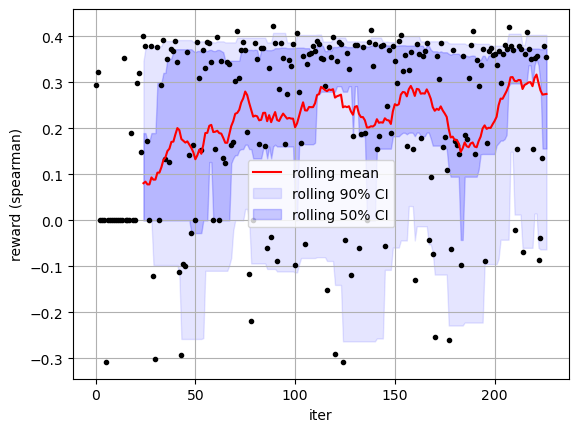

In [6]:
window=25
tmp = pd.DataFrame({'reward':result_dict['reward_scaler'].rewards})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
plt.plot(result_dict['reward_scaler'].rewards, 'k.')
plt.plot(tmp.rm, 'r-', label='rolling mean')
plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward (spearman)')
plt.show()

In [7]:
z = result_dict['x'].detach().cpu().numpy() 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
u = reducer.fit_transform(z)

zres = pd.DataFrame(u, columns=['u0', 'u1']).assign(prob=result_dict['node_prob'])

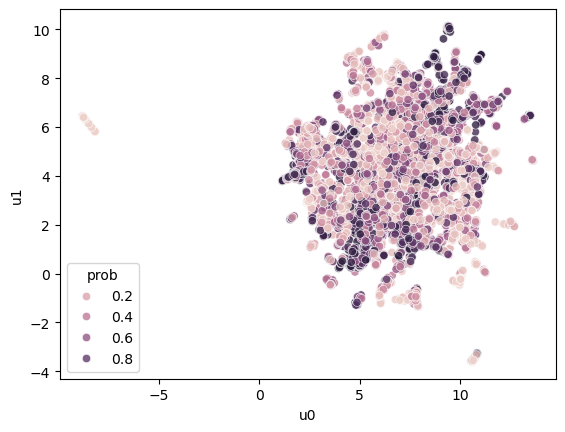

In [8]:
plt.figure()
sbn.scatterplot(x='u0', y='u1', hue='prob', data=zres, alpha=0.8)
plt.show()

In [14]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')

p = np.array(result_dict['node_prob'])
env = result_dict['env']

result_dict.keys()

dict_keys(['state_dict', 'node_prob', 'reward_scaler', 'args', 'x', 'actor', 'data', 'model_kwargs', 'training_kwargs', 'env'])

In [15]:
env.model_kwargs['checkpoint'] = True 
env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

qs=np.linspace(0.5,0.6, 2)
for i,q in enumerate(qs): 
    print(f'progress: {i+1}/{len(qs)}', end='\r')
    t = np.quantile(p, q=[q])[0]
    action = torch.tensor((1.*(p>t)), dtype=torch.float32)
    perf = env.run(action)

In [93]:

res2 = pd.DataFrame({'pathway':data['pathway_dict']['names'], 'weight':NS.f.weight.detach().cpu().numpy().ravel().tolist(), 'path_size':data['pathway_dict']['x'].sum(dim=0)})
res2.sort_values('weight', ascending=False).head(20)

AttributeError: 'Sequential' object has no attribute 'weight'

In [258]:
res.sort_values('weight', ascending=False).tail(20)

,pathway,weight,path_size
68,Transcriptional regulation by RUNX2,-0.002429,258.0
93,Chromatin modifying enzymes,-0.002695,230.0
74,Interferon Signaling,-0.005662,291.0
26,Hemostasis,-0.012546,702.0
64,Signaling by NTRKs,-0.017949,224.0
56,Parasitic Infection Pathways,-0.020326,244.0
71,Apoptosis,-0.029946,320.0
86,Signaling by TGFB family members,-0.032974,288.0
5,Metabolism of proteins,-0.033339,1362.0
23,Signaling by Interleukins,-0.038599,852.0


In [259]:
res2 = pd.DataFrame({'node_name':data.node_names_dict['function'], 'prob':NS(data.pathway_dict['x']).sigmoid().detach().cpu().numpy().ravel()})
res2.sort_values('prob', ascending=False)

,node_name,prob
95,PROTEIN__COMPLEX:P03231_P62987,0.993787
204,PROTEIN__COMPLEX:P59633_P62979,0.993787
216,PROTEIN__COMPLEX:P62979_Q7TFA0,0.993787
217,PROTEIN__COMPLEX:P62979_Q80H93,0.993787
218,PROTEIN__COMPLEX:P62987_Q7TFA0,0.993787
...,...,...
4044,PROTEIN__Q92794,0.471371
4725,PROTEIN__Q9NRG4,0.471371
601,PROTEIN__O60494,0.471127
5897,RNA__O15438,0.463056


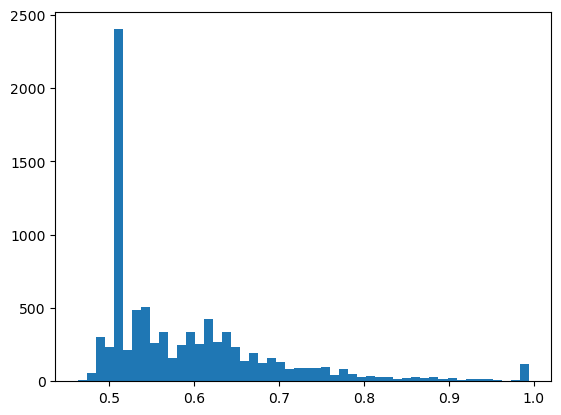

In [260]:
plt.figure()
plt.hist(res2.prob, bins=50)
plt.show()

In [261]:
# TP53 P04637 (target)
res2[lambda x: x.node_name == 'RNA__P04637']

,node_name,prob
6275,RNA__P04637,0.871626


In [225]:
data['node_names_dict']['function'][data['edge_index_dict']['function', 'to', 'output'][0,0]]

'RNA__P04637'

In [124]:
data['edge_index_dict']['function', 'to', 'output'][0,0]

tensor(6275)

In [45]:
# comparison VV 

In [46]:
NS = NodeSelector(100)
NS.load_state_dict(torch.load('../../processed_data/NodeSelector_state_dict.pt'))
data = torch.load('../../processed_data/data.pt')
res = pd.DataFrame({'pathway':data['pathway_dict']['names'], 'weight':NS.f.weight.detach().cpu().numpy().ravel().tolist()})
res.sort_values('weight', ascending=False).head(10)

,pathway,weight
88,Interleukin-1 family signaling,0.225939
44,Neutrophil degranulation,0.206191
2,Disease,0.198877
15,Signaling by GPCR,0.188353
38,SARS-CoV-2 Infection,0.181722
89,C-type lectin receptors (CLRs),0.169143
61,SARS-CoV-2-host interactions,0.164842
26,SARS-CoV Infections,0.151203
69,MAPK1/MAPK3 signaling,0.150320
1,Immune System,0.147247


In [47]:
res.sort_values('weight', ascending=False).tail(10)

,pathway,weight
70,Leishmania infection,-0.088491
81,Cellular response to chemical stress,-0.107307
35,Transcriptional Regulation by TP53,-0.111585
62,HIV Infection,-0.126189
20,Nervous system development,-0.131323
32,Vesicle-mediated transport,-0.135695
92,Host Interactions of HIV factors,-0.147454
98,Regulation of RUNX2 expression and activity,-0.149078
21,Axon guidance,-0.158255
8,Developmental Biology,-0.218283


In [54]:
device = 'cuda'

In [55]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import DeepGraphInfomax, SAGEConv

import umap 
from matplotlib import pyplot as plt 
import seaborn as sbn
import networkx as nx

In [56]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList([
            SAGEConv(in_channels, hidden_channels),
            SAGEConv(hidden_channels, hidden_channels),
            SAGEConv(hidden_channels, hidden_channels)
        ])

        self.activations = torch.nn.ModuleList()
        self.activations.extend([
            torch.nn.PReLU(hidden_channels),
            torch.nn.PReLU(hidden_channels),
            torch.nn.PReLU(hidden_channels)
        ])

    def forward(self, x, edge_index, batch_size):
        for conv, act in zip(self.convs, self.activations):
            x = conv(x, edge_index)
            x = act(x)
        return x[:batch_size]
    

def corruption(x, edge_index, batch_size):
    return x[torch.randperm(x.size(0))], edge_index, batch_size

class DGI(): 
    def __init__(self, data, embedding_dim): 

        self.data = data 
        self.embedding_dim = embedding_dim 
        self.model = None 

    def train(self, device, lr=1e-4, epochs=50, verbose=True, batch_size=256, workers=12):

        train_loader = NeighborLoader(self.data, num_neighbors=[10, 10, 25], batch_size=batch_size,
                              shuffle=True, num_workers=workers, input_nodes=None)

        model = DeepGraphInfomax(
            hidden_channels=self.embedding_dim, encoder=Encoder(self.data.x.size(1), self.embedding_dim),
            summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
            corruption=corruption).to(device)

        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs): 
            model.train()

            total_loss = total_examples = 0
            for batch in train_loader: 
                optimizer.zero_grad()
                pos_z, neg_z, summary = model(batch.x.to(device), batch.edge_index.to(device),
                                            batch.batch_size)
                loss = model.loss(pos_z, neg_z, summary)
                loss.backward()
                optimizer.step()
                total_loss += float(loss) * pos_z.size(0)
                total_examples += pos_z.size(0)

            if verbose: print(f'Epoch {epoch}: loss: {total_loss / total_examples:.4f}', end='\r')

        self.model = model

    def embed(self, device): 
        x = self.data.x
        edge_index = self.data.edge_index
        return self.model.encoder(x.to(device), edge_index.to(device), batch_size=self.data.x.size(0)).detach().cpu().numpy()


In [57]:
data = torch.load('../../processed_data/data.pt')

fdata = pyg.data.Data() 
fdata.edge_index = data['edge_index_dict']['function','to','function']
fdata.num_nodes = len(data['node_names_dict']['function'])
#fdata.x = torch.ones((len(data['node_names_dict']['function']),1), dtype=torch.float32)
#fdata.x = torch.stack((pyg.utils.degree(fdata.edge_index[0], num_nodes=fdata.num_nodes), 
#                       pyg.utils.degree(fdata.edge_index[1], num_nodes=fdata.num_nodes)), dim=-1)
fdata.x = torch.eye(fdata.num_nodes) # one hot encode nodes 

dgi = DGI(fdata, 128)
dgi.train(device='cuda', epochs=25)
z = dgi.embed(device='cuda').detach().cpu().numpy()


/home/teddy/miniconda3/envs/gsnn/lib/python3.12/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [179]:
len(data['node_names_dict']['function'])

2543

In [180]:
np.unique([x.split('__')[0] for x in data['node_names_dict']['function']])

array(['PROTEIN', 'RNA'], dtype='<U7')

In [181]:
fdata.edge_index.size(1)

7478

In [184]:
len(np.unique(data['node_names_dict']['function']))

2543

In [185]:
len(data['node_names_dict']['function'])

2543

In [201]:
# this should be 1 connected component (at least for single output)
data = torch.load('../../processed_data/data.pt')

G = nx.Graph()
row,col = data['edge_index_dict']['function','to','function'].detach().cpu().numpy()
for u,v in zip(np.array(data['node_names_dict']['function'])[row], np.array(data['node_names_dict']['function'])[col]): 
    G.add_edge(u,v)

for comp in nx.connected_components(G): 
    print(len(comp))
    if len(comp) < 5: print(comp)

9505


In [202]:
len(set(G.nodes()))

9505

In [203]:
len(set(data['node_names_dict']['function']))

9505

In [ ]:
# there are a bunch of proteins and RNAs that don't have any function edges

In [199]:
set(data['node_names_dict']['function']).difference(set(G.nodes()))

{'PROTEIN__COMPLEX:O00463_Q13546_Q15628',
 'PROTEIN__COMPLEX:O00505_P52294',
 'PROTEIN__COMPLEX:O43157_P08581',
 'PROTEIN__COMPLEX:P05107_P11215',
 'PROTEIN__COMPLEX:P05107_P20702',
 'PROTEIN__COMPLEX:P29466',
 'PROTEIN__COMPLEX:P46531_Q06330',
 'PROTEIN__COMPLEX:Q01718_Q8TCY5',
 'PROTEIN__COMPLEX:Q15022_Q15910',
 'PROTEIN__COMPLEX:Q8WWW0_Q9NS23',
 'PROTEIN__O00124',
 'PROTEIN__O00478',
 'PROTEIN__O00587',
 'PROTEIN__O00743',
 'PROTEIN__O14647',
 'PROTEIN__O14656',
 'PROTEIN__O14682',
 'PROTEIN__O14921',
 'PROTEIN__O15079',
 'PROTEIN__O15409',
 'PROTEIN__O43151',
 'PROTEIN__O43347',
 'PROTEIN__O43896',
 'PROTEIN__O43924',
 'PROTEIN__O60447',
 'PROTEIN__O75015',
 'PROTEIN__O75344',
 'PROTEIN__O75474',
 'PROTEIN__O75506',
 'PROTEIN__O75608',
 'PROTEIN__O75800',
 'PROTEIN__O75916',
 'PROTEIN__O94986',
 'PROTEIN__O95096',
 'PROTEIN__O95239',
 'PROTEIN__O95453',
 'PROTEIN__O95613',
 'PROTEIN__O95619',
 'PROTEIN__O95967',
 'PROTEIN__P00491',
 'PROTEIN__P00736',
 'PROTEIN__P01906',
 'PROTEIN_

In [186]:
len(G)

1962

In [189]:
reducer = umap.UMAP(min_dist=1)
u = reducer.fit_transform(z)


In [191]:
res = pd.DataFrame(u, columns=['u0','u1'])

for name, xpath in zip(data['pathway_dict']['names'], data['pathway_dict']['x'].T): 
    inpath = (xpath.detach().cpu().numpy() == 1)
    res = res.assign(**{name:inpath})
res.head()

,u0,u1,Signal Transduction,Immune System,Disease,Gene expression (Transcription),RNA Polymerase II Transcription,Generic Transcription Pathway,Metabolism of proteins,Innate Immune System,...,Regulation of TP53 Activity,Peptide ligand-binding receptors,G1/S Transition,Transcriptional regulation by RUNX1,Ub-specific processing proteases,Transmission across Chemical Synapses,Host Interactions of HIV factors,Regulation of RUNX2 expression and activity,Toll Like Receptor TLR1:TLR2 Cascade,Toll Like Receptor 2 (TLR2) Cascade
0,11.099720,6.303533,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-10.704615,-0.153701,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-8.082451,-0.416147,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,9.328453,7.399037,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-9.124731,2.843528,False,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


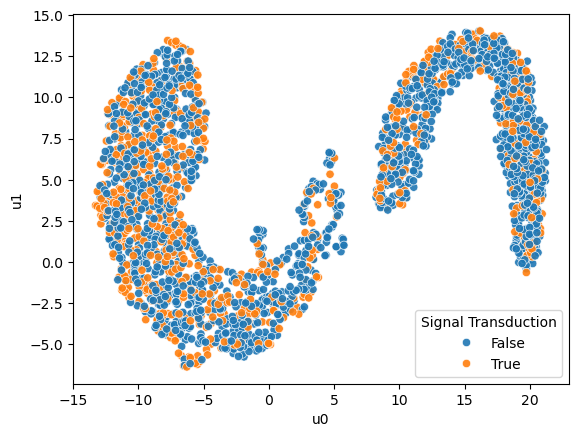

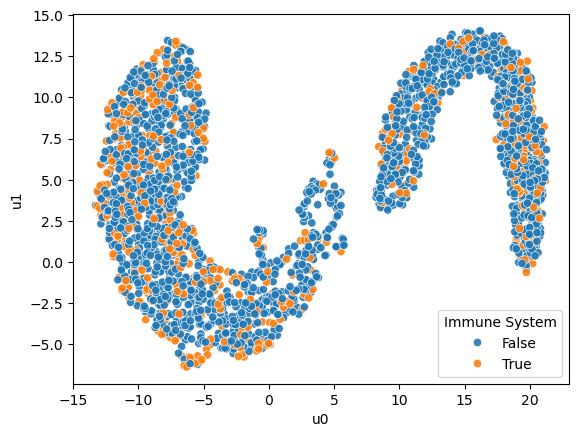

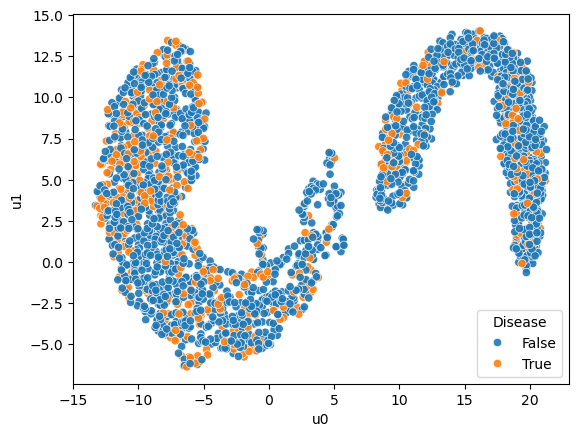

In [192]:
for path_name in data['pathway_dict']['names'][:3]: 
    plt.figure()
    sbn.scatterplot(x='u0', y='u1', hue=path_name, data=res, alpha=0.9)
    plt.show()

In [20]:
model.encoder()

Encoder(
  (convs): ModuleList(
    (0): SAGEConv(1, 512, aggr=mean)
    (1-2): 2 x SAGEConv(512, 512, aggr=mean)
  )
  (activations): ModuleList(
    (0-2): 3 x PReLU(num_parameters=512)
  )
)

In [ ]:
print(torch.__version__)

2.2.2


: 

: 